In [1]:
import scarches as sca
import scanpy as sc
import matplotlib as mpl
import numpy as np
import pandas as pd
import os
import sankey
import matplotlib.pyplot as plt
import sc_utils
import sklearn.metrics
import tensorflow as tf

Using TensorFlow backend.


In [2]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
mpl.rcParams["figure.figsize"] = (12, 8)

# Reference-based analysis of bronchoalveolar lavage fluid single-cell data from COVID-19 patients

Here we explore the possibility of using [scArches](https://www.biorxiv.org/content/10.1101/2020.07.16.205997v1) (Lotfollahi et al., 2020) to build a reference single-cell dataset of bronchoalveolar lavage (BAL) fluid from patients with COVID-19 and use it to analyse other BAL samples.

As reference dataset we used samples from COVID-positive patients from [Grant et al., 2020](https://www.biorxiv.org/content/10.1101/2020.08.05.238188v2) and as a query dataset we used COVID-negative samples from the same preprint. Both datasets have published cell type annotations which we used to assess scArches performance at capturing biological variability in its latent space and at predicting cell type labels.

In this notebook we \
— download the data, \
— preprocess it, \
— train scArches model for the Reference dataset, \
— project a Query dataset on it, \
— predict the cell type labels and \
— analyse results.

## Data
Please, use the `get-data.sh` script to download `RAW.tar` and 2 csv files into `./data` directory in the current folder and untar the tar. We use data from the Grant et al., 2020 preprint: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE155249

In [ ]:
%%bash
if [[ ! -d covid-data ]]; then
    mkdir covid-data
fi

wget "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE155249&format=file" -O covid-data/GSE155249_RAW.tar
cd covid-data
tar xf GSE155249_RAW.tar
cd -
wget "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE155249&format=file&file=GSE155249_main-metadata%2Ecsv%2Egz" -O covid-data/main-metadata.csv.gz
wget "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE155249&format=file&file=GSE155249_supplement-metadata%2Ecsv%2Egz" -O covid-data/supplement-metadata.csv.gz

gunzip covid-data/main-metadata.csv.gz
gunzip covid-data/supplement-metadata.csv.gz

In [4]:
!ls covid-data | head

GSE155249_RAW.tar
GSM4698176_Sample_1_filtered_feature_bc_matrix.h5
GSM4698176_Sample_1_raw_feature_bc_matrix.h5
GSM4698177_Sample_2_filtered_feature_bc_matrix.h5
GSM4698177_Sample_2_raw_feature_bc_matrix.h5
GSM4698178_Sample_3_filtered_feature_bc_matrix.h5
GSM4698178_Sample_3_raw_feature_bc_matrix.h5
GSM4698179_Sample_4_filtered_feature_bc_matrix.h5
GSM4698179_Sample_4_raw_feature_bc_matrix.h5
GSM4698180_Sample_5_filtered_feature_bc_matrix.h5


## Preprocessing
We will create a scanpy object with only COVID-positive samples and train scArches model on it, using this tutorial https://scarches.readthedocs.io/en/latest/zenodo_pancreas_from_scratch.html as a reference. We want to use the same cells as in Figure 4A of the preprint.

We will use `filtered_feature_bc_matrix` files and the published metadata file for this dataset. The metadata tells us which cells were filtered out in the preprint and also contains the cell type labels for the cells.

We do a simple preprocessing with log-normalization of expression values for cells. This will give us the same values as used in the preprint, and this is a common step for single-cell analysis, so that we ensure easy reuse of the model.

In [5]:
def rename_genes(names):
    names = names.str.replace("^GRCh38_+", "")
    names = names.str.replace("^SARS-CoV-2i_", "SARS-CoV-2-")
    names = names.str.replace("SARS-CoV-2-antisense", "Antisense")
    return names

In [6]:
samples = []
files = os.listdir("covid-data")
for i in range(1, 8): # 1..7 COVID-positive samples
    for f in files:
        if f"Sample_{i}_fil" in f:
            break
    ds = sc.read_10x_h5(f"covid-data/{f}")
    ds.var_names = rename_genes(ds.var_names)
    ds.var_names_make_unique(join=".")
    ds.obs_names = ds.obs_names.str.replace("-\d$", "") + f"-{i - 1}"
    samples.append(ds)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Vari

In [7]:
data = sc.concat(samples)

In [8]:
meta = pd.read_csv("covid-data/main-metadata.csv", index_col=0)

In [9]:
data = data[data.obs_names.isin(meta.index), :]

Dropping SARS-CoV-2 genes, as we want the model to be based only on human genes.

In [10]:
data = data[:, ~data.var_names.str.match("^SARS-CoV")]

In [11]:
data

View of AnnData object with n_obs × n_vars = 27930 × 33538

In [12]:
data.obs = meta

All the samples come from one study

In [13]:
data.obs["Study"] = "Grant_et_al_2020"

In [14]:
condition_key = "Study"

In [15]:
data.obs.Study = data.obs.Study.astype("category")

In [16]:
sc.pp.normalize_total(data, target_sum=1e4)

In [17]:
sc.pp.log1p(data)

In [18]:
data.obs.Sample = data.obs.Sample.astype("category")

In [19]:
sc.pp.highly_variable_genes(data, n_top_genes=4000, batch_key="Sample")

... storing 'Sample type' as categorical
... storing 'Cluster' as categorical


In [20]:
adata = data[:, data.var.highly_variable]

## Train scArches reference model

In [21]:
network = sca.models.scArches(task_name='grant_covid_ref',
                              x_dimension=adata.shape[1],
                              z_dimension=10,
                              architecture=[128, 128],
                              gene_names=adata.var_names.tolist(),
                              conditions=adata.obs[condition_key].unique().tolist(),
                              alpha=0.001,
                              loss_fn='sse',
                              model_path="./models/scArches/")

scArches' network has been successfully constructed!
scArches' network has been successfully compiled!


In [22]:
network.train(adata,
              condition_key=condition_key,
              n_epochs=200,
              batch_size=128,
              save=True,
              retrain=False)

scArches' network has been successfully compiled!
cvae's weights has been successfully restored!


## Explore its latent space

In [44]:
latent_adata = network.get_latent(adata, condition_key)

In [45]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

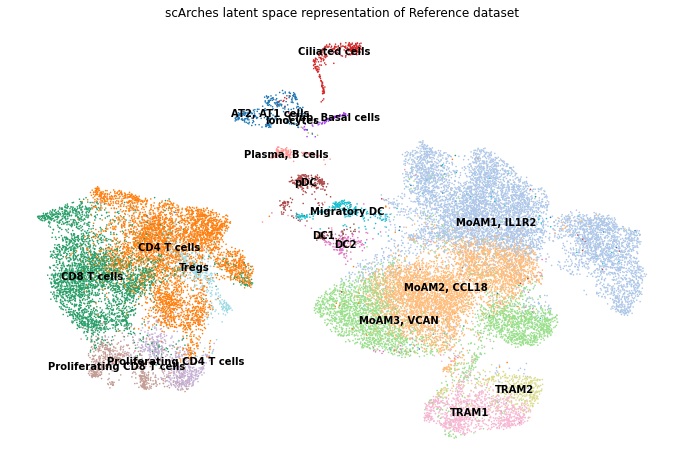

In [47]:
sc.pl.umap(latent_adata, color="Cluster",
           frameon=False, legend_loc="on data", size=10, 
           title="scArches latent space representation of Reference dataset")

This is the latent space representation of COVID-positive samples from Grant et al. 2020, figure 4A. Cell type annotations are taken from the preprint.

This representation is very similar to the UMAP plot in the preprint, supporting the notion that the analysis in the preprint and scArches both capture underlying biology of the cell types.

## Prepare COVID-negative dataset

Now we can project COVID-negative samples from Patient 6 on this Reference with scArches.

In [26]:
p6samples = []
files = os.listdir("covid-data")
for i in (8, 9): # COVID-negative samples
    for f in files:
        if f"Sample_{i}_fil" in f:
            break
    ds = sc.read_10x_h5(f"covid-data/{f}")
    ds.var_names = rename_genes(ds.var_names)
    ds.var_names_make_unique(join=".")
    ds.obs_names = ds.obs_names.str.replace("-\d$", "") + f"-{i - 1}"
    p6samples.append(ds)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [27]:
p6data = sc.concat(p6samples)

In [28]:
p6meta = pd.read_csv("covid-data/supplement-metadata.csv", index_col=0)

In [29]:
p6data = p6data[p6data.obs_names.isin(p6meta.index), :]

In [30]:
p6data = p6data[:, ~p6data.var_names.str.match("^SARS-CoV")]

In [31]:
p6data

View of AnnData object with n_obs × n_vars = 11217 × 33538

In [32]:
p6data.obs = p6meta.loc[p6data.obs_names, :]

This is still the same study

In [33]:
p6data.obs["Study"] = "Grant_et_al_2020"

In [34]:
p6data.obs.Study = p6data.obs.Study.astype("category")

In [35]:
sc.pp.normalize_total(p6data, target_sum=1e4)
sc.pp.log1p(p6data)

In [36]:
hvg_names = data.var_names[data.var.highly_variable]

In [37]:
p6adata = p6data[:, p6data.var_names.isin(hvg_names)]

## Project COVID-negative samples on the Reference

In [38]:
new_network = sca.operate(network,
                          new_task_name="patient6_query",
                          new_conditions=[])

scArches' network has been successfully constructed!
scArches' network has been successfully compiled!
scArches' network has been successfully compiled!


In [39]:
new_network.train(p6adata,
                  train_size=0.8,
                  condition_key=condition_key,
                  n_epochs=50,
                  batch_size=512, 
                  save=True,
                  retrain=False)

scArches' network has been successfully compiled!
cvae's weights has been successfully restored!


After training, let's get both datasets' representation in the common latent space.

In [40]:
both = sc.concat([adata, p6adata])

In [41]:
latent2 = new_network.get_latent(both, condition_key)

In [42]:
sc.pp.neighbors(latent2)
sc.tl.umap(latent2)

... storing 'Sample type' as categorical
... storing 'Cluster' as categorical


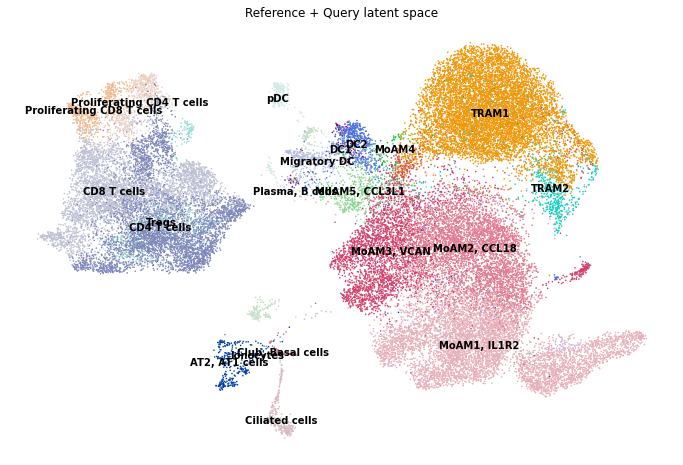

In [43]:
sc.pl.umap(latent2, color="Cluster",
           frameon=False, legend_loc="on data", size=10, title="Reference + Query latent space")

This is the common latent space for Reference (COVID-positive samples) and Query (COVID-negative samples) datasets, with cell type annotations taken from the preprint.

Though the overall configuration of clusters changed, the structure remains the same and agrees with the preprint figure S4e.

## Classify cells in the Query dataset

We will use weighted KNN classifier as in here: https://scarches.readthedocs.io/en/latest/pancreas_pipeline.html#Project-query-and-reference-data-in-the-latent-space

In [48]:
n_neighbors = 10
threhsold = 0.7

In [49]:
train_latent = new_network.get_latent(adata, condition_key)
valid_latent = new_network.get_latent(p6adata, condition_key)

In [50]:
sca.ann.weighted_knn(train_latent,
                     valid_latent,
                     label_key="Cluster",
                     n_neighbors=n_neighbors,
                     threshold=threhsold,)

Weighted KNN with n_neighbors = 10 and threshold = 0.7 ... finished!
Number of correctly classified samples: 8905
Number of misclassified samples: 840
Number of samples classified as unknown: 1472


In [51]:
sklearn.metrics.f1_score(valid_latent.obs.Cluster, valid_latent.obs.pred_Cluster, average="weighted")

0.8184874810812762

Weighted F1-score for predictions is ~0.82

In [52]:
sc.pp.neighbors(valid_latent)
sc.tl.umap(valid_latent)

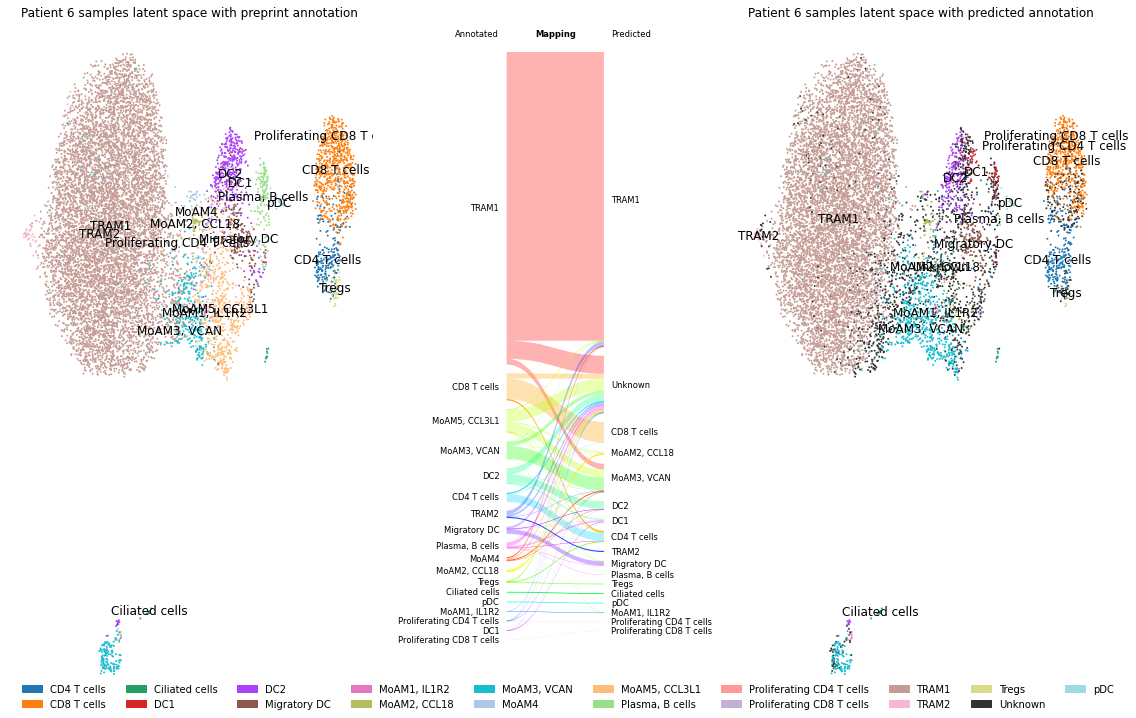

In [88]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 10), gridspec_kw={
    "width_ratios": [1, 1, 1],
    "wspace": 0
})
sc.pl.umap(valid_latent, 
           color="Cluster", 
           frameon=False, 
           size=15, 
           legend_loc="on data",
           title="Patient 6 samples latent space with preprint annotation",
           ax=axes[0],
           show=False,
           legend_fontweight="normal",
           legend_fontsize=12)

cluster_colors = pd.Series(valid_latent.uns["Cluster_colors"])
cluster_colors.index = valid_latent.obs.Cluster.cat.categories
sankey.sankey(valid_latent.obs.Cluster, 
              valid_latent.obs.pred_Cluster,
              title="Mapping",
              title_left="Annotated",
              title_right="Predicted",
              ax=axes[1]);
cluster_colors["Unknown"] = "#333333"
cluster_colors = cluster_colors.sort_index()
pred_cluster_colors = cluster_colors.loc[cluster_colors.index.isin(valid_latent.obs.pred_Cluster.unique())]
sc.pl.umap(valid_latent, 
           color="pred_Cluster", 
           frameon=False, 
           size=15, 
           legend_loc="on data",
           title="Patient 6 samples latent space with predicted annotation",
           ax=axes[2],
           palette=list(pred_cluster_colors),
           show=False,
           legend_fontweight="normal",
           legend_fontsize=12)
handles = []
for i in cluster_colors.index:
    handles.append(mpl.patches.Patch(color=cluster_colors[i], label=i))
fig.legend(handles=handles, loc="lower center", frameon=False, ncol=cluster_colors.size // 2 + 1)
fig.tight_layout()
p = axes[1].get_position()
p.y0 += 0.05
axes[1].set_position(p)

On the left is the latent space of Query dataset only, with cell type labels taken from the preprint. 

On the right is the same latent space, but the cell type labels are taken from weighted-KNN predictions based on scArches' latent space. 

In the middle is the sankey diagram showing how labels from the preprint correspond to predicted labels: thickness of the alluvial lines is proportional to the number of cells that belong to the label on the left and are predicted with the label on the right.

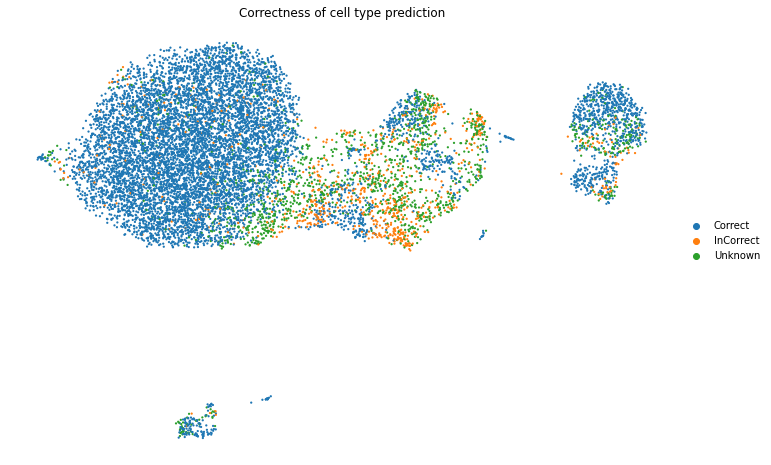

In [54]:
sc.pl.umap(valid_latent, 
           color="evaluation", 
           frameon=False, 
           size=20,
           title="Correctness of cell type prediction")

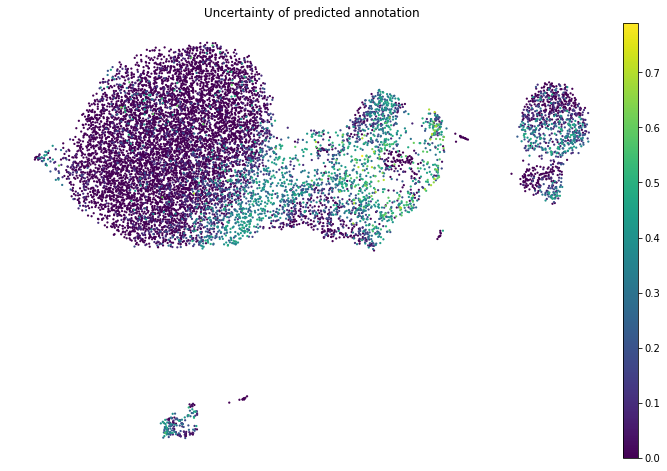

In [55]:
sc.pl.umap(valid_latent, color='uncertainty', size=20, frameon=False, title="Uncertainty of predicted annotation")

Most predictions by weighted KNN in the common latent space derived from scArches model are correct, dominated by TRAM1 predictions.

`MoAM5` and `MoAM4` clusters are absent in the Reference dataset, and here their predicted labels are split between `Unknown` and `MoAM3` cluster, which is transcriptionally closest to them.

Interestingly, `MoAM3` cluster is split into 2 subclusters in the latent space. Let's investigate possible causes for this split.

## What is this cluster at the bottom?

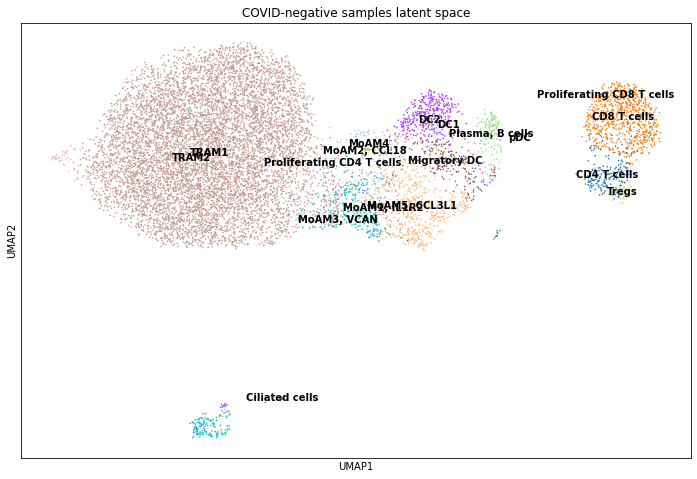

In [56]:
sc.pl.umap(valid_latent, 
           color="Cluster", 
           size=10, 
           legend_loc="on data",
           title="COVID-negative samples latent space")

Text(0.5, 1.0, 'Distribution of Y coordinate in UMAP')

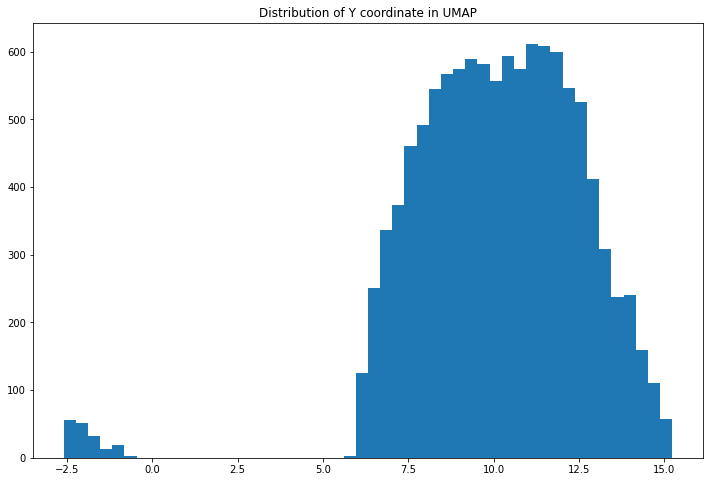

In [57]:
plt.hist(valid_latent.obsm["X_umap"][:, 1], bins=50)
plt.title("Distribution of Y coordinate in UMAP")

Manually pick the top subcluster

In [58]:
our_cells = np.where(valid_latent.obsm["X_umap"][:, 1] < 0)[0]

In [59]:
valid_latent.obs["strange_cluster"] = False
valid_latent.obs.iloc[our_cells, -1] = True
valid_latent.obs.strange_cluster = valid_latent.obs.strange_cluster.astype("category")

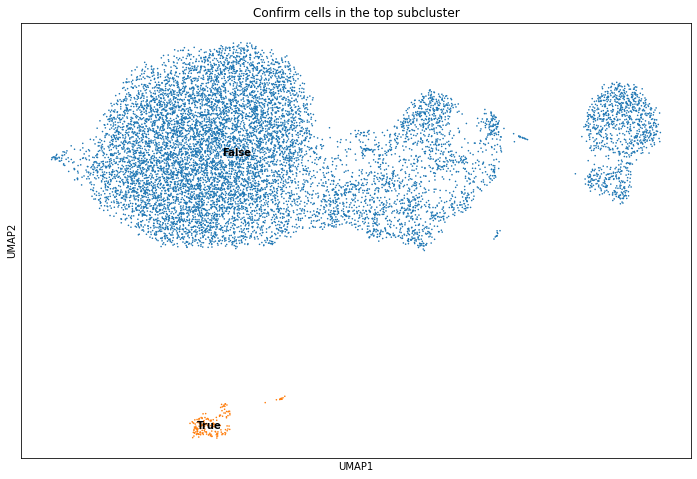

In [60]:
sc.pl.umap(valid_latent, 
           color="strange_cluster", 
           size=10, 
           legend_loc="on data",
           title="Confirm cells in the top subcluster")

Let's subset on MoAM3 cluster and run differential gene expressino between it's two subclusters: Top and Main.

In [70]:
p6data_mom3 = p6data[p6data.obs.Cluster == "MoAM3, VCAN", :].copy()

In [71]:
p6data_mom3.obs["Subcluster"] = "Main"

In [72]:
mom3_strange_cluster = p6data_mom3.obs_names.isin(valid_latent.obs_names[valid_latent.obs.strange_cluster])

In [73]:
p6data_mom3.obs.loc[mom3_strange_cluster, "Subcluster"] = "Bottom"

In [74]:
p6data_mom3.obs.Subcluster = p6data_mom3.obs.Subcluster.astype("category")

In [75]:
sc.tl.rank_genes_groups(p6data_mom3, "Subcluster", method="wilcoxon", n_genes=0)

... storing 'Sample type' as categorical
... storing 'Cluster' as categorical


In [76]:
p6data_mom3.raw = p6data_mom3

In [77]:
markers = sc_utils.get_markers(p6data_mom3, "Subcluster")

In [78]:
markers.sort_values(
    "avg_logFC", 
    ascending=False
).groupby("cluster").head(20).sort_values(["cluster", "avg_logFC"], ascending=[False, False])

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
33712,2.224207e-05,28.837553,0.308917,0.000000,2.224207e-05,Main,FOSB
33723,3.759752e-05,28.585779,0.302548,0.000000,3.759752e-05,Main,LENG8
33819,1.066916e-03,28.429333,0.257962,0.000000,1.066916e-03,Main,AC004687.1
34104,4.569391e-02,27.995043,0.194268,0.000000,4.569391e-02,Main,SLC7A5
33549,3.262623e-54,8.201941,0.955414,0.116788,3.262623e-54,Main,MALAT1
33548,3.132677e-57,7.970925,0.977707,0.051095,3.132677e-57,Main,MT-ND4
33543,2.422596e-59,7.855285,0.993631,0.058394,2.422596e-59,Main,MT-ND2
33538,1.387408e-59,7.748575,1.000000,0.094891,1.387408e-59,Main,MT-ND4L
33539,1.387408e-59,7.389705,0.996815,0.102190,1.387408e-59,Main,MT-ND1
33546,6.732356e-59,7.208743,0.990446,0.087591,6.732356e-59,Main,MT-ATP6


The Main subcluster is high on mitochondrial genes, and has a few genes not detected in the other subcluster. The Bottom subcluster seems to be Tissue-Resident Alveolar Macrophages (FABP4+, C1QA+, APOC1+). 

But how is it different from regular TRAM cluster?

Let's subset on TRAM1 cluster and the Bottom subcluster and run differential gene expression between them.

In [79]:
p6data_mom3_tram = p6data[
    (p6data.obs.Cluster == "TRAM1") 
        | (
            (p6data.obs_names.isin(valid_latent.obs_names[valid_latent.obs.strange_cluster]))
            & (p6data.obs.Cluster == "MoAM3, VCAN")
        )
    , :
].copy()

In [80]:
p6data_mom3_tram.obs.Cluster.value_counts()

TRAM1          8008
MoAM3, VCAN     137
Name: Cluster, dtype: int64

In [81]:
sc.tl.rank_genes_groups(p6data_mom3_tram, "Cluster", method="wilcoxon", n_genes=0)

... storing 'Sample type' as categorical
... storing 'Cluster' as categorical


In [82]:
p6data_mom3_tram.raw = p6data_mom3_tram

In [83]:
markers2 = sc_utils.get_markers(p6data_mom3_tram, "Cluster")

In [84]:
markers2.sort_values(
    "avg_logFC", 
    ascending=False
).groupby("cluster").head(20).sort_values(["cluster", "avg_logFC"], ascending=[False, False])

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
34005,8.533835e-07,27.870739,0.283217,0.000000,8.533835e-07,TRAM1,LENG8
33987,6.121482e-07,27.863020,0.286339,0.000000,6.121482e-07,TRAM1,SH2B3
34182,1.338445e-05,27.730286,0.255869,0.000000,1.338445e-05,TRAM1,AC004687.1
34164,1.067065e-05,27.697840,0.258242,0.000000,1.067065e-05,TRAM1,TANC2
34434,1.239165e-04,27.629652,0.230894,0.000000,1.239165e-04,TRAM1,FOSB
34414,1.069630e-04,27.511805,0.232642,0.000000,1.069630e-04,TRAM1,PSME4
35077,3.119416e-03,27.158854,0.188686,0.000000,3.119416e-03,TRAM1,KSR1
35296,5.853899e-03,27.047127,0.179071,0.000000,5.853899e-03,TRAM1,TSEN2
35349,6.826582e-03,27.027950,0.176698,0.000000,6.826582e-03,TRAM1,PIEZO1
35452,8.828596e-03,26.985407,0.172577,0.000000,8.828596e-03,TRAM1,FNIP1


There are no significant markers that distinguish the Bottom subcluster from TRAM1 cluster.

However, there are many genes which are not detected in the Bottom subcluster. 

Let's look at the technical variables: number of detected UMIs and number of detected genes.

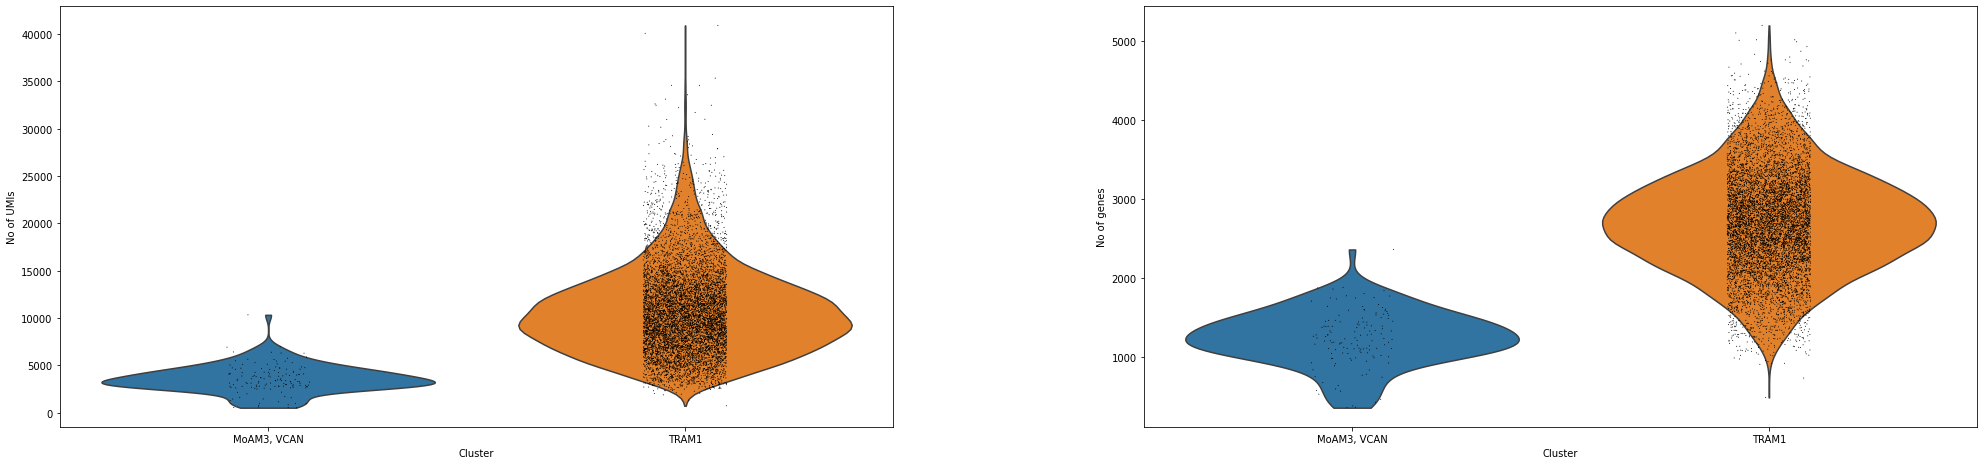

In [85]:
sc.pl.violin(p6data_mom3_tram, ["No of UMIs", "No of genes"], groupby="Cluster")

The Bottom subcluster of MoAM3 cluster seems to be low-quality cells, but with a TRAM signature.

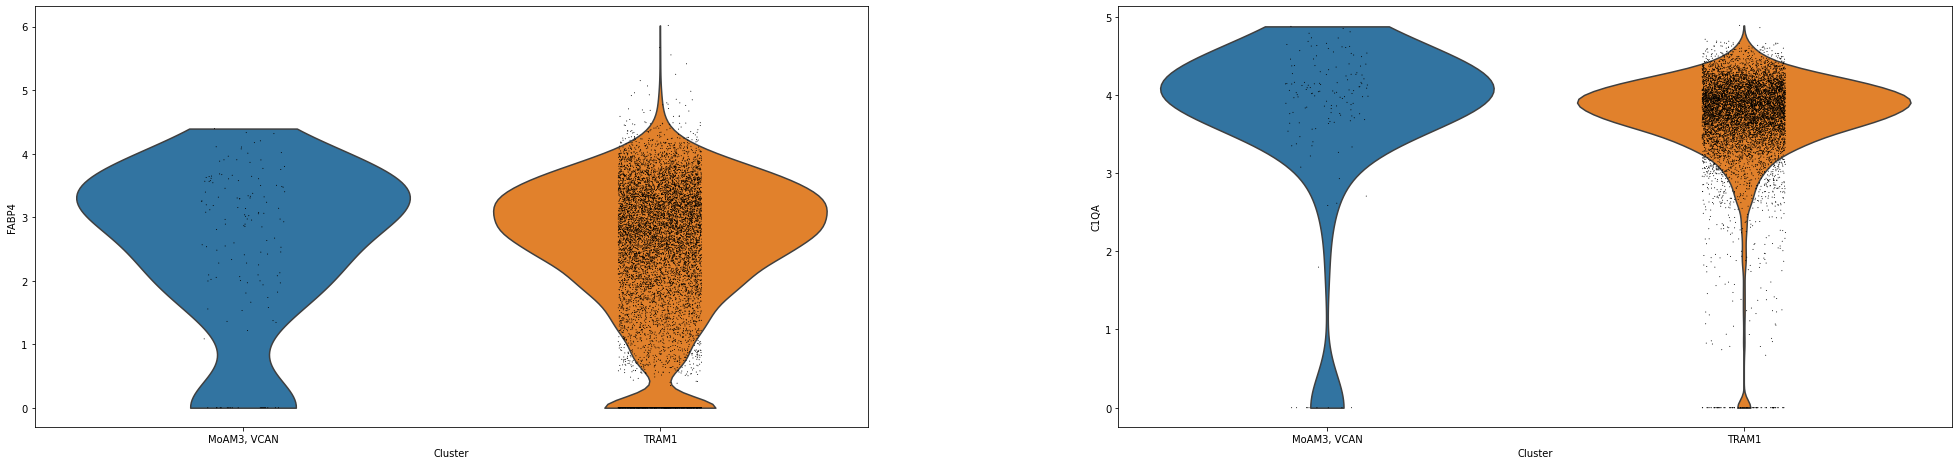

In [86]:
sc.pl.violin(p6data_mom3_tram, ["FABP4", "C1QA"], groupby="Cluster")

**Conclusion**:

scArches was able to train the model that recapitulated manual cell type annotation after integration in Grant et al. 2020.

scArches projection of Query COVID-negative samples on Reference COVID-positive dataset also recapitulated manual cell type annotation in the preprint. Cell type predictions based on the latent space were mostly accurate, with weighted F1-score of ~0.82

While projecting the Query dataset in its latent space, scArches resolved a subcluster of MoAM3 cluster, which was masked by the analysis in the preprint. After investigation, we think that the subcluster is likely a low-UMI Tissue-Resident Alveolar Macrophages instead of Monocyte-Derived Alveolar Macrophages.